# **Text mining: SENTIMENT ANALYSIS**

## 🎓 Master’s Program in Data Science & Advanced Analytics  
**Nova IMS** | June 2025  
**Course:** Text Mining

## 👥 Team **Group 34**  
- **[Philippe Dutranoit]** | [20240518]  
- **[Diogo Duarte]** | [20240525]  
- **[Rui luz]** | [20211628]  
- **[Rodrigo Sardinha]** | [20211627]  

## 📊 Goal of the notebook

This notebook focuses on feature selection and engineering for our text-mining project: predicting market sentiment (Bearish, Bullish, Neutral) from Twitter data.  


# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from transformers import AutoTokenizer, RobertaForSequenceClassification, pipeline

import torch
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

c:\Users\ruibl\anaconda3\envs\nel_2025_env_full\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load Data

In [2]:
# X_train = pd.read_csv('X_train.csv')
# y_train = pd.read_csv('Y_train.csv')
# X_test = pd.read_csv('X_val.csv')
# y_test = pd.read_csv('Y_val.csv')

X_train = pd.read_csv('../Data/X_train.csv')
y_train = pd.read_csv('../Data/y_train.csv')
X_test = pd.read_csv('../Data/X_val.csv')
y_test = pd.read_csv('../Data/y_val.csv')

# Pre-trained Pipeline

Here we are using the Huggingface pipeline("sentiment-analysis") to evaluate the performance of a pre-trained Transformer model on our validation set. The model is used in inference mode only, without being trained on our data. Providing a baseline to compare later with our own fine-tuned model.

In [3]:
# Define reusable pipeline evaluation function
def evaluate_pipeline_model(model_name, val_texts, y_true):
    print(f"\n--- Evaluating model: {model_name} ---")

    # Some models do not support device_map='auto' → safe to try without
    if "distilbert" in model_name:
        classifier = pipeline(
            "sentiment-analysis",
            model=model_name,
            tokenizer=model_name,
            batch_size=16,
            truncation=True
        )
    else:
        classifier = pipeline(
            "sentiment-analysis",
            model=model_name,
            tokenizer=model_name,
            batch_size=16,
            device_map="auto",
            truncation=True
        )

    # Run pipeline
    preds = classifier(val_texts)

    # Choose correct label map depending on model
    # First, check what labels look like
    example_label = preds[0]['label']

    if example_label in ["negative", "positive", "neutral"]:
        label_map = {
            "negative": 0,
            "positive": 1,
            "neutral": 2
        }
    elif example_label in ["LABEL_0", "LABEL_1", "LABEL_2"]:
        label_map = {
            "LABEL_0": 0,
            "LABEL_1": 1,
            "LABEL_2": 2
        }
    elif example_label in ["NEG", "POS", "NEU"]:
        label_map = {
            "NEG": 0,
            "POS": 1,
            "NEU": 2
        }

    else:
        raise ValueError(f"Unknown label format: {example_label}")

    # Convert predictions
    y_pred_pipeline = [label_map[pred['label']] for pred in preds]

    # Print classification report
    print(classification_report(y_true, y_pred_pipeline, digits=4))

     # Plot confusion matrix
    cm = confusion_matrix(y_true, y_pred_pipeline)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0,1,2], yticklabels=[0,1,2])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()

#### Baseline Evaluation


--- Evaluating model: cardiffnlp/twitter-roberta-base-sentiment-latest ---


c:\Users\ruibl\anaconda3\envs\nel_2025_env_full\Lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenc

              precision    recall  f1-score   support

           0     0.4907    0.4583    0.4740       288
           1     0.6084    0.4519    0.5186       385
           2     0.7371    0.8074    0.7707      1236

    accuracy                         0.6831      1909
   macro avg     0.6121    0.5726    0.5878      1909
weighted avg     0.6740    0.6831    0.6751      1909



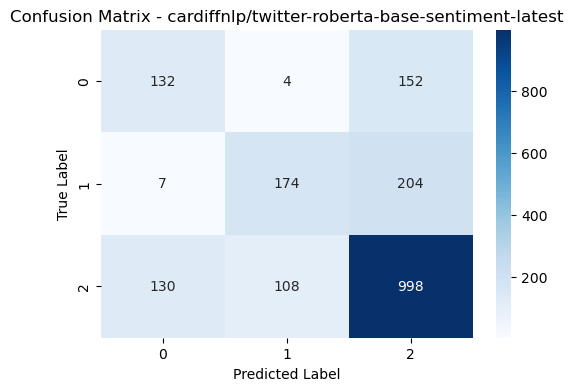


--- Evaluating model: cardiffnlp/twitter-xlm-roberta-base-sentiment ---


c:\Users\ruibl\anaconda3\envs\nel_2025_env_full\Lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


              precision    recall  f1-score   support

           0     0.3432    0.4444    0.3873       288
           1     0.3816    0.2052    0.2669       385
           2     0.6712    0.7217    0.6955      1236

    accuracy                         0.5757      1909
   macro avg     0.4653    0.4571    0.4499      1909
weighted avg     0.5633    0.5757    0.5626      1909



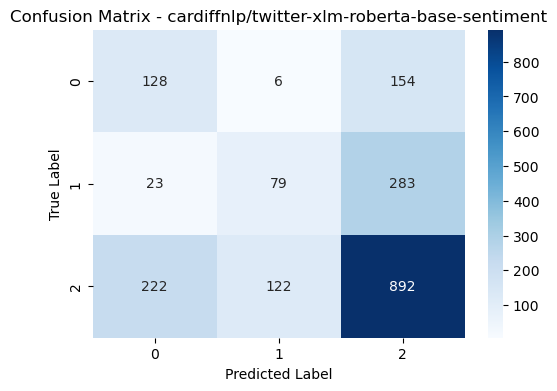


--- Evaluating model: finiteautomata/bertweet-base-sentiment-analysis ---


c:\Users\ruibl\anaconda3\envs\nel_2025_env_full\Lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


              precision    recall  f1-score   support

           0     0.5046    0.5729    0.5366       288
           1     0.5032    0.4104    0.4521       385
           2     0.7311    0.7500    0.7404      1236

    accuracy                         0.6548      1909
   macro avg     0.5796    0.5778    0.5764      1909
weighted avg     0.6509    0.6548    0.6515      1909



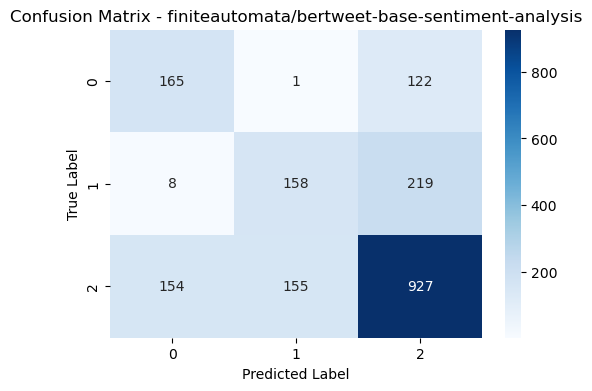

In [4]:
# --- Run loop over your selected models ---

# Prepare texts and true labels once
val_texts = X_test["text"].tolist()
y_true = y_test["label"].tolist()

# List of models to test
model_list = [
    'cardiffnlp/twitter-roberta-base-sentiment-latest',
    'cardiffnlp/twitter-xlm-roberta-base-sentiment',
    'finiteautomata/bertweet-base-sentiment-analysis'
]

# Run evaluation for each model
for model_name in model_list:
    evaluate_pipeline_model(model_name, val_texts, y_true)

# Pre-trained LM for Embeddings + Training a Classifier

### Extract CLS Embeddings

In [5]:
# If emb[0] is a list of layer outputs → take the last one
# If emb[0] is already a vector → just use it.

def extract_cls_embeddings(texts, feature_extractor):
    print("Extracting embeddings...")
    embeddings = feature_extractor(texts, batch_size=16)
    
    # Detect if emb[0] is a list of layers
    first_emb = embeddings[0][0]
    if isinstance(first_emb, list):
        print("Detected multi-layer embeddings → using last layer.")
        cls_embeddings = np.array([np.array(emb[0][-1]) for emb in embeddings])
    else:
        print("Detected single-layer embeddings.")
        cls_embeddings = np.array([np.array(emb[0]) for emb in embeddings])
    
    print(f"Extracted CLS embeddings shape: {cls_embeddings.shape}")
    return cls_embeddings

### Train and Evaluate Classifier

In [6]:
def train_and_evaluate_classifier(classifier, X_train, y_train, X_val, y_val):
    print(f"\n--- Training {classifier.__class__.__name__} ---")
    
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_val)
    
    report = classification_report(y_val, y_pred, digits=4, output_dict=True)
    print(classification_report(y_val, y_pred, digits=4))
    
    cm = confusion_matrix(y_val, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0,1,2], yticklabels=[0,1,2])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix - {classifier.__class__.__name__}")
    plt.show()
    
    macro_f1 = report['macro avg']['f1-score']
    accuracy = accuracy_score(y_val, y_pred)
    return macro_f1, accuracy

### Run feature-extraction + test different classifiers

In [7]:
# Load feature-extraction pipeline
feature_extractor = pipeline(
    "feature-extraction",
    model='cardiffnlp/twitter-roberta-base-sentiment-latest',
    tokenizer='cardiffnlp/twitter-roberta-base-sentiment-latest',
    batch_size=16,
    device_map="auto",
    truncation=True
)

# Extract embeddings
X_train_texts = X_train["text"].tolist()
y_train_labels = y_train["label"].tolist()

X_val_texts = X_test["text"].tolist()
y_val_labels = y_test["label"].tolist()

X_train_features = extract_cls_embeddings(X_train_texts, feature_extractor)
X_val_features = extract_cls_embeddings(X_val_texts, feature_extractor)


c:\Users\ruibl\anaconda3\envs\nel_2025_env_full\Lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Extracting embeddings...
Detected multi-layer embeddings → using last layer.
Extracted CLS embeddings shape: (7634, 768)
Extracting embeddings...
Detected multi-layer embeddings → using last layer.
Extracted CLS embeddings shape: (1909, 768)


### Define classifiers and run loop


--- Training LogisticRegression ---
              precision    recall  f1-score   support

           0     0.6861    0.6528    0.6690       288
           1     0.7556    0.7065    0.7302       385
           2     0.8604    0.8875    0.8738      1236

    accuracy                         0.8156      1909
   macro avg     0.7674    0.7489    0.7577      1909
weighted avg     0.8130    0.8156    0.8139      1909



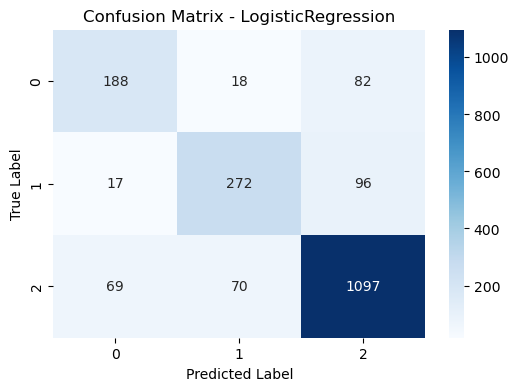


--- Training SVC ---
              precision    recall  f1-score   support

           0     0.7523    0.5694    0.6482       288
           1     0.8328    0.6597    0.7362       385
           2     0.8326    0.9337    0.8802      1236

    accuracy                         0.8235      1909
   macro avg     0.8059    0.7209    0.7549      1909
weighted avg     0.8205    0.8235    0.8162      1909



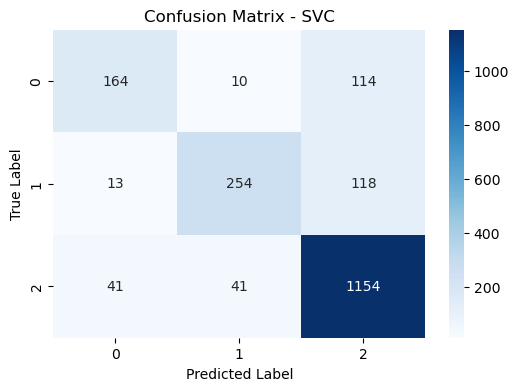


--- Training RandomForestClassifier ---
              precision    recall  f1-score   support

           0     0.7749    0.5139    0.6180       288
           1     0.8706    0.5766    0.6937       385
           2     0.8059    0.9539    0.8737      1236

    accuracy                         0.8114      1909
   macro avg     0.8171    0.6815    0.7285      1909
weighted avg     0.8143    0.8114    0.7988      1909



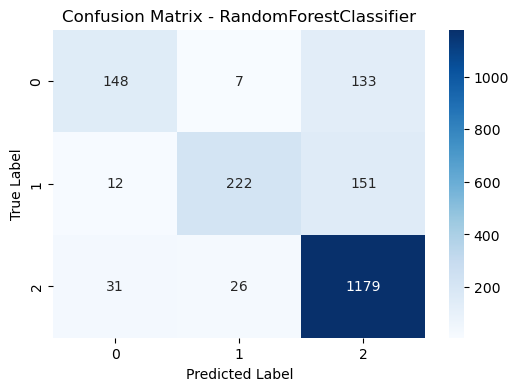


--- Training GradientBoostingClassifier ---
              precision    recall  f1-score   support

           0     0.7443    0.5660    0.6430       288
           1     0.8235    0.6545    0.7294       385
           2     0.8309    0.9304    0.8779      1236

    accuracy                         0.8198      1909
   macro avg     0.7996    0.7170    0.7501      1909
weighted avg     0.8164    0.8198    0.8125      1909



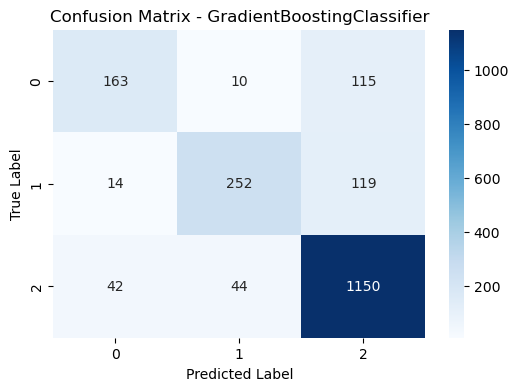


--- Training XGBClassifier ---


c:\Users\ruibl\anaconda3\envs\nel_2025_env_full\Lib\site-packages\xgboost\training.py:183: UserWarning: [00:41:26] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


              precision    recall  f1-score   support

           0     0.7619    0.6111    0.6782       288
           1     0.8350    0.6571    0.7355       385
           2     0.8422    0.9369    0.8870      1236

    accuracy                         0.8313      1909
   macro avg     0.8130    0.7350    0.7669      1909
weighted avg     0.8286    0.8313    0.8250      1909



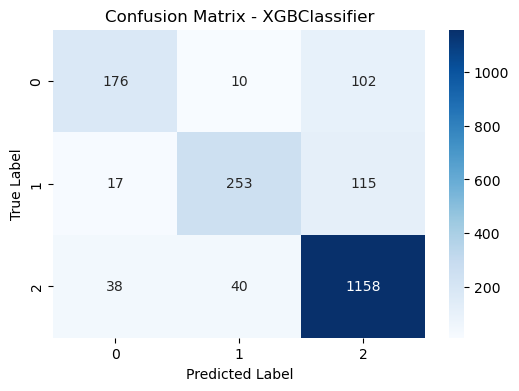


--- Training MLPClassifier ---
              precision    recall  f1-score   support

           0     0.6793    0.6840    0.6817       288
           1     0.7725    0.7584    0.7654       385
           2     0.8807    0.8843    0.8825      1236

    accuracy                         0.8287      1909
   macro avg     0.7775    0.7756    0.7765      1909
weighted avg     0.8285    0.8287    0.8286      1909



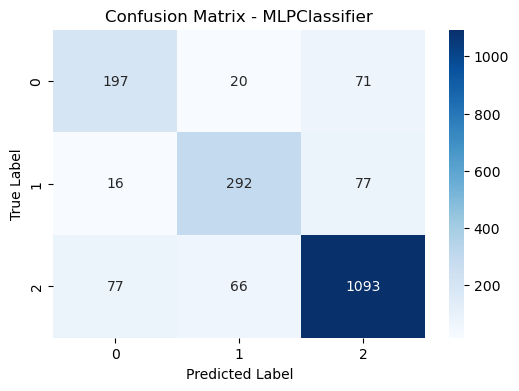

In [8]:
# List of classifiers to test
classifier_list = [
    LogisticRegression(max_iter=1000),
    SVC(),
    RandomForestClassifier(n_estimators=100),
    GradientBoostingClassifier(n_estimators=100),
    XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'),
    MLPClassifier(hidden_layer_sizes=(128, 64), max_iter=300)
]

# To store results
results = []

# Run evaluation for each classifier
for clf in classifier_list:
    macro_f1, acc = train_and_evaluate_classifier(clf, X_train_features, y_train_labels, X_val_features, y_val_labels)
    results.append({
        'Classifier': clf.__class__.__name__,
        'Macro F1': macro_f1,
        'Accuracy': acc
    })

### Summary results table

In [9]:
# Convert results to DataFrame and sort by Macro F1
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='Macro F1', ascending=False).reset_index(drop=True)

print("\n--- Classifier Comparison Table ---")
display(results_df)



--- Classifier Comparison Table ---


,Classifier,Macro F1,Accuracy
0,MLPClassifier,0.776527,0.828706
1,XGBClassifier,0.766903,0.831325
2,LogisticRegression,0.757665,0.815610
3,SVC,0.754899,0.823468
4,GradientBoostingClassifier,0.750079,0.819801
5,RandomForestClassifier,0.728454,0.811420


# Fine-tuning best model

## Prepocessing

In [ ]:
# Define the model
MODEL_NAME = 'cardiffnlp/twitter-roberta-base-sentiment-latest'

### Preprocessing with a tokenizer

#### Define tokenizer

In [ ]:
# load the tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

### Encode the dataset

In [ ]:
# Tokenize training set
train_encodings = tokenizer(
    X_train["text"].tolist(),   # convert to list of strings
    padding=True,               # pad to max length in batch
    truncation=True,            # truncate long tweets
    return_tensors="pt"         # return PyTorch tensors
)

In [ ]:
# Tokenize validation set
val_encodings = tokenizer(
    X_test["text"].tolist(),
    padding=True,
    truncation=True,
    return_tensors="pt"
)

In [ ]:
# Check shape of tokenized data
print("Train input_ids shape:", train_encodings["input_ids"].shape)
print("Validation input_ids shape:", val_encodings["input_ids"].shape)

### Dataset and DataLoader

In [ ]:
# Custom Dataset class for our BERT model
class TweetDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {
            'input_ids': self.encodings['input_ids'][idx],
            'attention_mask': self.encodings['attention_mask'][idx],
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }
        return item


#### Instantiate dataset

In [ ]:
# Convert labels to list
train_labels = y_train["label"].tolist()
val_labels = y_test["label"].tolist()

# Create Dataset objects
train_dataset = TweetDataset(train_encodings, train_labels)
val_dataset = TweetDataset(val_encodings, val_labels)

#### Create DataLoaders

In [ ]:
# Set batch size (typical: 16 or 32)
batch_size = 16

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# Check one batch from train_loader
batch = next(iter(train_loader))
print(batch.keys())
print(batch['input_ids'].shape)
print(batch['attention_mask'].shape)
print(batch['labels'].shape)

## Model prep

## Load the model

In [ ]:
# Load model with 3 output labels
model = RobertaForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=3)

In [ ]:
print(model)

## Setup model training

## Model Training